In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import astropy.constants as const
from scipy.integrate import quad

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathptmx}",  # Times Roman
    "hatch.linewidth": 3.0,
})
sns.set_context("paper",font_scale=1.5)
sns.set_palette("pastel")

##  $a = a(\log{M_{bh}}, \log{\sigma})$

/tmp/ipykernel_1229/3503609804.py:14: RuntimeWarning: divide by zero encountered in divide
  sigma_star = mbh*t/gamma/(a0**2-a**2)/200
/tmp/ipykernel_1229/3503609804.py:16: RuntimeWarning: divide by zero encountered in divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_1229/3503609804.py:17: RuntimeWarning: invalid value encountered in multiply
  return prefactor * exp_term * jacobian


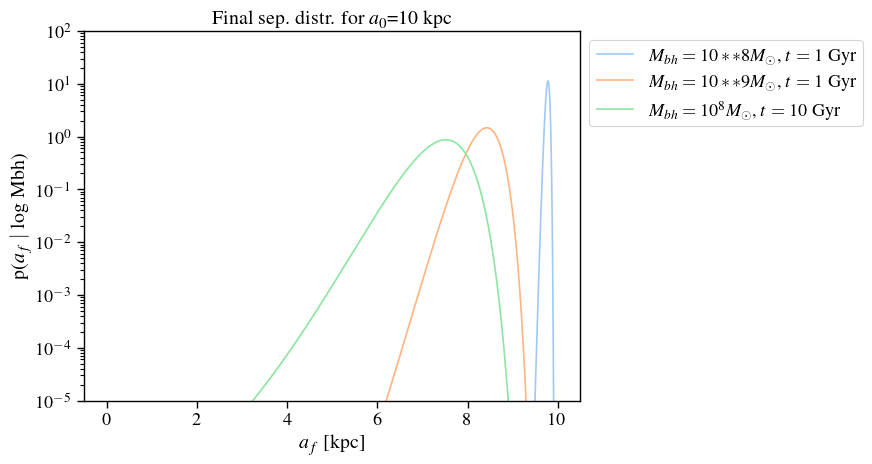

In [4]:
a0 = 10
a = np.linspace(0,a0,1000)
# mbh-sigma constants
epsilon = 0.38
beta = 5.64
alpha = 8.32
# tdf constants
coulomb_log = 3
gamma = 19/ coulomb_log / 25 / 200 * 1e8
def pa_sigma(a,mbh,t,a0):
     """p(a|mbh) for a = a(mbh, sigma)"""
     logmbh = np.log10(mbh)
     prefactor = 1/(np.sqrt(2*np.pi)*epsilon/beta) 
     sigma_star = mbh*t/gamma/(a0**2-a**2)/200
     exp_term = np.exp(-(np.log10(sigma_star) - 1/beta*logmbh + alpha/beta)**2 / (2*epsilon**2/beta**2))
     jacobian = 2*a/(a0**2-a**2)/np.log(10)
     return prefactor * exp_term * jacobian

plt.figure()
plt.plot(a,pa_sigma(a,mbh = 1e8,t = 1, a0 = a0),label='$M_{bh}=10**8M_\odot$,~$t=1$ Gyr')
plt.plot(a,pa_sigma(a,mbh = 1e9,t = 1, a0 = a0),label='$M_{bh}=10**9M_\odot$,~$t=1$ Gyr')
plt.plot(a,pa_sigma(a,mbh = 1e8,t = 10, a0 = a0),label='$M_{bh}=10^8M_\odot$,~$t=10$ Gyr')
plt.title(rf"Final sep. distr. for $a_0$={a0} kpc")
plt.xlabel("$a_{f}$ [kpc]")
plt.ylabel("p($a_{f}$ $|$ log Mbh)")
plt.yscale('log')
plt.ylim((1e-5,1e2))
plt.legend(bbox_to_anchor=(1,1));

Check normalization. Note that scipy.quad cannot integrate over a very large range. (quad samples the integration interval and might miss peaks)

In [5]:
quad(pa_sigma, 0, a0, args=(1e8,1,a0))

(1.0, 8.415477274176541e-10)

##  $a = a(\log{M_{bh}}, \log{\sigma}, a_0)$

### uniform prior on $a_0$

/tmp/ipykernel_1229/3503609804.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/gamma/(a0**2-a**2)/200
/tmp/ipykernel_1229/3503609804.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_1229/3503609804.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_1229/4269501055.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_unif_integrand, alower, amax, args=(a_,mbh,t,amin,amax))[0])


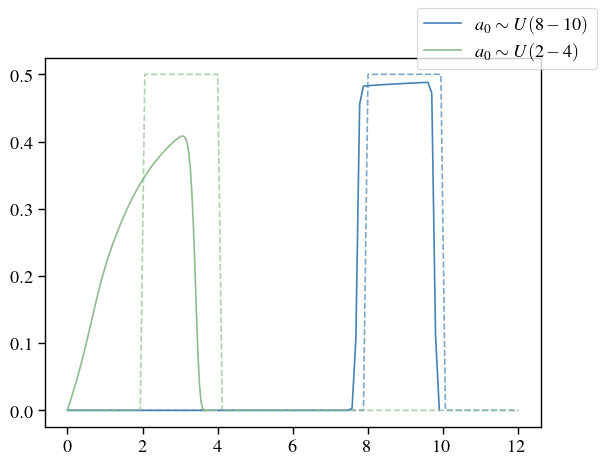

In [6]:
def p_a0_uniform(amin,amax):
    """define uniform prior over (amin,amax)"""
    return 1/(amax-amin)

def pa_sigma_a0_unif_integrand(a0, a, mbh, t, amin, amax):
    """return the integrand, i.e. p(a|mbh,sigma,a)*p(sigma|mbh)*p(a|mbh)"""
    return pa_sigma(a, mbh, t, a0) * p_a0_uniform(amin, amax)

def pa_sigma_a0_unif(amin,amax,mbh,t):
    """for each af(a) value, integrate over all a0"""
    a = np.linspace(0,amax,100)
    p = []
    for a_ in a:
        alower = np.max([a_,amin])
        p.append(quad(pa_sigma_a0_unif_integrand, alower, amax, args=(a_,mbh,t,amin,amax))[0])
    return a, p

def plot_pa_unif(amin,amax,mbh,t,ax,clr):
    # function for plotting pa, uniform a0
    # find p(a|mbh)
    a,p = pa_sigma_a0_unif(amin,amax,mbh,t)
    # calculate prior over large range for pretty plot
    unif = lambda x,amin,amax: 0 if (x<amin) or (x> amax) else 1/(amax-amin)
    apr = np.linspace(0,12,100)
    pr = [unif(a_,amin,amax) for a_ in apr]
    # plot
    ax.plot(a,p,c=clr,label=rf"$a_0\sim U({{{amin}}}-{{{amax}}})$")
    ax.plot(apr,pr,linestyle="--",c=clr,alpha=0.7)

fig,ax = plt.subplots()
plot_pa_unif(8,10,1e8,1,ax,"steelblue")
plot_pa_unif(2,4,1e8,1,ax,"darkseagreen")
fig.legend();


Evolve individually and check with p(a)

/tmp/ipykernel_1229/3503609804.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/gamma/(a0**2-a**2)/200
/tmp/ipykernel_1229/3503609804.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_1229/3503609804.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_1229/4269501055.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_unif_integrand, alower, amax, args=(a_,mbh,t,amin,amax))[0])
/tmp/ipykernel_1229/1578276036.py:9: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*sigma))


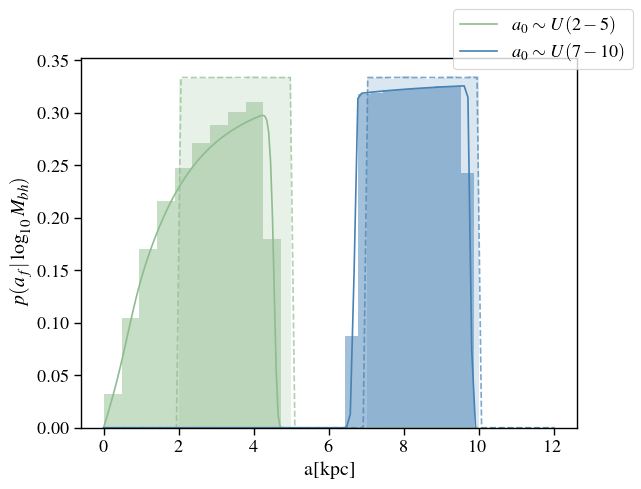

In [7]:
def plot_monte_carlo_unif_a0(amin,amax,mbh,t,ax,clr):
    N = 1000000
    logmbh = np.log10(mbh)
    # sample a0
    a0 = np.random.uniform(amin,amax,N)
    # sample sigma
    logsigma = np.random.normal(loc=1/beta*logmbh-alpha/beta,scale=epsilon/beta,size=N)
    sigma = 10**logsigma*200
    af = np.sqrt(a0**2 - mbh*t/(gamma*sigma))
    # plot
    ax.hist(af,density=True,color=clr,alpha=0.5)
    ax.hist(a0,density=True,color=clr,alpha=0.2)

fig,ax = plt.subplots()
plot_pa_unif(2,5,1e8,1,ax,"darkseagreen")
plot_monte_carlo_unif_a0(2,5,1e8,1,ax,"darkseagreen")

plot_pa_unif(7,10,1e8,1,ax,"steelblue")
plot_monte_carlo_unif_a0(7,10,1e8,1,ax,"steelblue")

ax.set_xlabel("a[kpc]")
ax.set_ylabel(r"$p(a_f|\log_{10}{M_{bh}})$")
fig.legend();

Check that analytical solution matches numerical. 
Initially I plugged in a wrong formula to mathematica and got a closed form solution. But the correct integral does not have a closed form for the uniform $p(a_0)$ case

In [8]:
# from scipy.special import erf
def unif_anlt(a,mbh,t,a1,a2):
    # defind constants
    c0 = 2*a/(a2-a1)/np.log(10)/(np.sqrt(2*np.pi)*epsilon/beta)
    c1 = mbh*t/gamma/200
    c2 = 1/beta*np.log10(mbh) - alpha/beta
    c3 = 1/(2*epsilon**2/beta**2)
    c4 = c0 * (-np.log(10)/2)
    # calculate upper and lower limit after substitution
    U = np.log10(c1/(a2**2-a**2))
    al = np.array([np.max([a_,a1]) for a_ in a])
    L = np.log10(c1/(al**2-a**2))
    # the evaluated integral. from here down is not correct
    def f(c1,c2,c3,X,a):
        """this is not wrong. I plugged in the wrong integrand 
            to mathematica and got this"""
        term1 = np.exp(c1*(c1+8*c3*(c2-X))/16/c3)
        term2 = erf((c1+4*c3*(c2-X))/4/np.sqrt(c3))
        term3 = np.exp((a**2-c1*X)/2)
        return term1*term2/term3
    termU = f(c1,c2,c3,U,a)
    termL = f(c1,c2,c3,L,a)
    # mask out nan terms
    zeromask = al != a1
    termL[zeromask] = 0
    return c4*(-termU+termL)*np.sqrt(np.pi/c3/4)

### Gaussian prior on $a_0$

/tmp/ipykernel_1229/3503609804.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/gamma/(a0**2-a**2)/200
/tmp/ipykernel_1229/3503609804.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_1229/3503609804.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_1229/2868902261.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_gaus_integrand, a_, aupper, args=(a_,mbh,t,amean_ ,std_))[0])


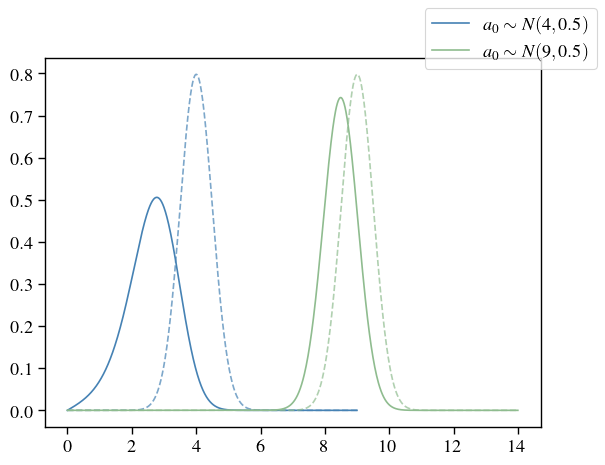

In [9]:
def p_a0_gaussian(a0_ ,amean_ ,std_):
    prefactor = 1/ (np.sqrt(2 * np.pi * std_**2))
    expterm = np.exp(- (a0_ - amean_)**2 / (2 * std_**2))
    return prefactor * expterm

def pa_sigma_a0_gaus_integrand(a0, a, mbh, t, amean_ ,std_):
    return pa_sigma(a, mbh, t, a0) * p_a0_gaussian(a0 ,amean_ ,std_)

def pa_sigma_a0_gaus(amean_ ,std_,mbh,t):
    aupper = amean_ + std_ * 10
    a = np.linspace(0,aupper,1000)
    prior = p_a0_gaussian(a,amean_,std_)
    p = []
    for a_ in a:
        p.append(quad(pa_sigma_a0_gaus_integrand, a_, aupper, args=(a_,mbh,t,amean_ ,std_))[0])
    return a, p, prior

def plot_pa_gaus(amean_ ,std_,mbh,t,ax,clr):
    # function for plotting pa, gaussian a0
    # find p(a|mbh)
    a,p,pr = pa_sigma_a0_gaus(amean_ ,std_,mbh,t)
    # plot
    ax.plot(a,p,c=clr,label=rf"$a_0\sim N({{{amean_}}},{{{std_}}})$")
    ax.plot(a,pr,linestyle="--",c=clr,alpha=0.7)

fig,ax = plt.subplots()
plot_pa_gaus(4,0.5,1e8,2,ax,"steelblue")
plot_pa_gaus(9,0.5,1e8,2,ax,"darkseagreen")
fig.legend();

Check with Monte Carlo

/tmp/ipykernel_1229/3503609804.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sigma_star = mbh*t/gamma/(a0**2-a**2)/200
/tmp/ipykernel_1229/3503609804.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  jacobian = 2*a/(a0**2-a**2)/np.log(10)
/tmp/ipykernel_1229/3503609804.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * exp_term * jacobian
/tmp/ipykernel_1229/2868902261.py:15: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  p.append(quad(pa_sigma_a0_gaus_integrand, a_, aupper, args=(a_,mbh,t,amean_ ,std_))[0])
/tmp/ipykernel_1229/2922111164.py:9: RuntimeWarning: invalid value encountered in sqrt
  af = np.sqrt(a0**2 - mbh*t/(gamma*sigma))


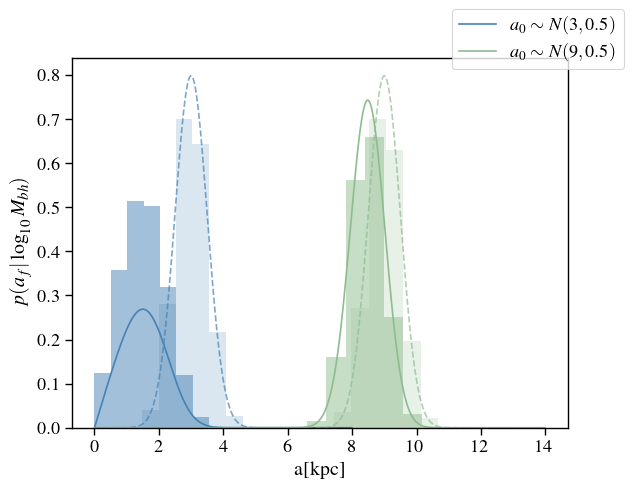

In [21]:
def plot_monte_carlo_gaus_a0(amean_,std_,mbh,t,ax,clr):
    N = 10000000
    logmbh = np.log10(mbh)
    # sample a0
    a0 = np.random.normal(loc=amean_,scale=std_,size=N)
    # sample sigma
    logsigma = np.random.normal(loc=1/beta*logmbh-alpha/beta,scale=epsilon/beta,size=N)
    sigma = 10**logsigma*200
    af = np.sqrt(a0**2 - mbh*t/(gamma*sigma))
    # plot
    ax.hist(af,density=True,color=clr,alpha=0.5)
    ax.hist(a0,density=True,color=clr,alpha=0.2)
    return af

fig,ax = plt.subplots()
plot_pa_gaus(3,0.5,1e8,2,ax,"steelblue")
plot_monte_carlo_gaus_a0(3,0.5,1e8,2,ax,"steelblue")

plot_pa_gaus(9,0.5,1e8,2,ax,"darkseagreen")
plot_monte_carlo_gaus_a0(9,0.5,1e8,2,ax,"darkseagreen")

ax.set_xlabel("a[kpc]")
ax.set_ylabel(r"$p(a_f|\log_{10}{M_{bh}})$")
fig.legend();